In [1]:
import json
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "B+_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
num_tapered = molecule['num_tapered']
print(num_tapered+num_qubits, num_qubits)

10 5


B+_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


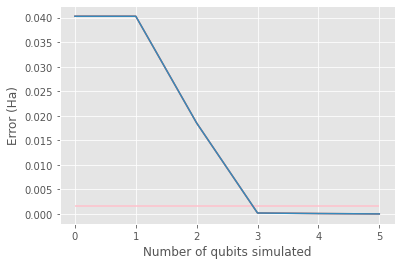

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

In [5]:
#anz_ops = mol_circ.sufficient_anz_terms(uccsd)

In [6]:
#import random
ham_red = mol_circ.ham_reduced[num_sim_q]
#anz_indices = [random.randint(0, len(uccsd.keys())) for i in range(1)]
#print(anz_indices)
anz_ops = ['XIZXX', 'IYZXX']
#for Be anz_ops = ['ZYZXX', 'IIYXX', 'XIIYX', 'IYZXX']
#for C anz_ops = ['ZXYII', 'XZZXX', 'XIZYX']
#for LiH anz_ops = ['YXIIIIXX', 'IIIIIYZX', 'IIIIYXYY', 'XZIIZYIY', 'IIIIXZYI', 'XXIIIIYX', 'IIIIXXXY', 'IXIIXIIY', 'IYIIXIIY', 'IYIIZZZX', 'IIIIXXYX']
#for HF  anz_ops = ['XYIIXXII', 'XYIIIIXX', 'IYIIZXII', 'YYIIZZYX', 'IYIIZZZX', 'YYIIIIYX', 'XXIIYXII', 'YXIIYYII']
#anz_indices = [49, 97, 71, 72] #for C
#anz = {op:uccsd[op] for op in [list(uccsd.keys())[i] for i in anz_indices]}
#anz = uccsd
#anz_ops = ['ZXIYX', 'XZZXX', 'YZZXX']
anz = {op:uccsd[op] for op in anz_ops}

#anz=uccsd
anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = mol_circ.init_param
bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])
qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
#qc.draw(output='mpl')

3-qubit reduced Hamiltonian: {'III': -22.7593764549541, 'ZII': -0.6311272707456288, 'ZZI': -0.6311272707456251, 'IZI': 0.5076986673038641, 'IZZ': 1.4639787552454517e-09, 'ZZZ': 0.47713820047797767, 'ZIZ': 0.4771382004779789, 'IIZ': -0.3192201327080312, 'XZI': 0.015814815627810057, 'XII': -0.015814815627810057, 'YXY': -0.04813123763377622, 'XXY': -9.662980095228088e-19, 'XYY': -8.163110589764265e-20, 'YYY': -0.02937231980195385, 'YYX': 8.163110589764265e-20, 'XYX': -0.02937231980195385, 'XXX': -0.04813123763377622, 'YXX': 9.662980095228086e-19, 'ZYY': 0.04813123763377622, 'IYY': 1.1105789478887618e-18, 'IXY': -6.777361327908706e-19, 'ZXY': -0.02937231980195385, 'ZXX': 1.1105789478887618e-18, 'IXX': 0.04813123763377622, 'IYX': 0.02937231980195385, 'ZYX': 6.777361327908706e-19, 'IIY': -1.463980947103219e-09, 'ZIY': 1.348150961071065e-32, 'ZZY': 1.348150961071065e-32, 'IZY': -1.4639809468863785e-09, 'IZX': 8.934008642169223e-10, 'ZZX': -2.3096883088044568e-26, 'ZIX': -2.3096883088044568e-2

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


In [7]:
len(mol_circ.init_param)

4

# Performing the simulation *without* noise

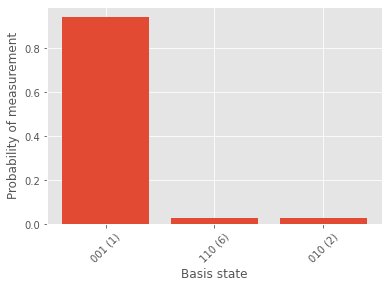

*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...


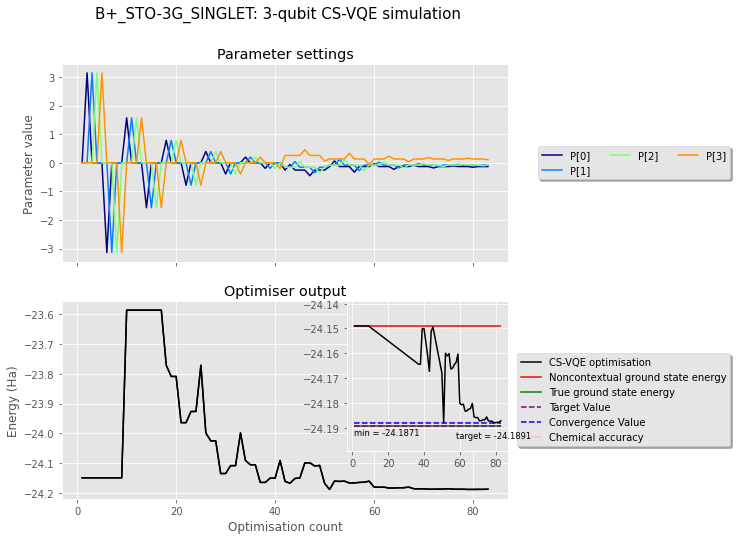

In [8]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False,
                                show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [9]:
#param_hist = [config for param, config in cs_vqe_results['params'].items()]
#init_params = np.array(list(zip(*param_hist))[-1])

In [10]:
cs_vqe_results['result']

-24.18792739859057

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [11]:
from qiskit import IBMQ
from utils.circuit_execution_tools import remote_circuit_execution
with open('data/token.txt', 'r') as file:
    TOKEN = file.read()
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
data, raw_data = remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=100, qfi_resamples=500, backend='ibmq_bogota')

runtime_job._start_websocket_client:WARNING:2021-10-26 13:03:36,524: An error occurred while streaming results from the server for job c5rum0qkh8krlc7egmmg:
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 328, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/tim/anaconda3/lib/python3.7/site-packages/websocket/_app.py", line 369, in run_forever\n  

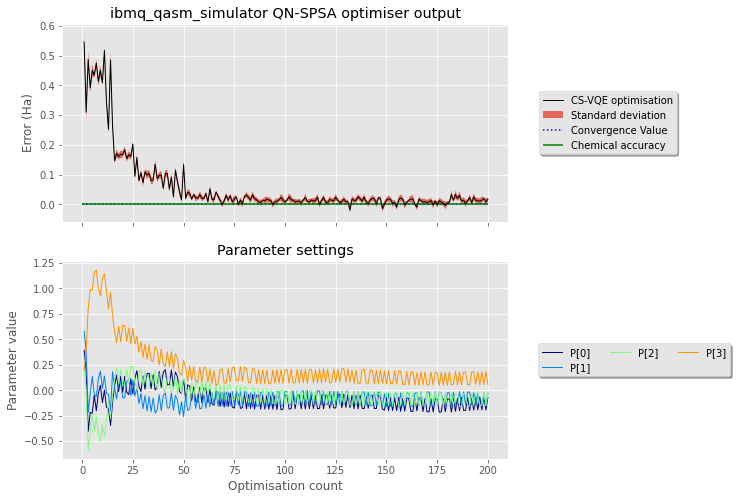

In [19]:
fig = plot.plot_parameter_settings_alt(data)

In [14]:
#import json 

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [15]:
list(mol_circ.init_param)

[-5.017098624361127e-19,
 4.140835425734262e-19,
 8.361831040601878e-19,
 -6.901392376223771e-19]